<a href="https://colab.research.google.com/github/victorbuenog/Flapper/blob/main/Flappertorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import time
import pickle

import numpy
import scipy
import torch
import torch.nn as nn
from torch.distributions import Categorical

from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.path as mpath
from matplotlib.markers import MarkerStyle
import matplotlib.font_manager as fm
plt.ioff()

import gym
from gym import wrappers
from gym import spaces

import imageio

In [2]:
class InitialCondition(object):

    def __init__(self, distance=None, f2=None, A2=None, goal=None):
        self.distance = distance if distance is not None else 21.5
        self.A1 = 2.0
        self.f1 = 1.0
        self.A2 = 2.0 if A2 is None else A2
        self.f2 = 1.0 if f2 is None else f2
        self.goal = goal if goal is not None else 21.5

        self.u2 = numpy.pi * self.A2 * self.f2 * numpy.sqrt(2 * SwimmerEnv.Ct / SwimmerEnv.Cd)
        self.v2 = -self.A2*(2 * numpy.pi * self.f2)
        self.v_flow = self.A1*self.f1*numpy.cos(2*numpy.pi*self.f1*(-SwimmerEnv.dt))*numpy.exp(-SwimmerEnv.dt/SwimmerEnv.T)
        self.flow_agreement = self.v2 * self.v_flow

    def random(self, randomize_fields=[]):
        if 'distance' in randomize_fields:
            self.distance = random.uniform(10,30)
        if 'f2' in randomize_fields:
            self.f2 = random.uniform(0.5, 1.5)
        if 'A2' in randomize_fields:
            self.A2 = random.uniform(.5, 3.0)
        if 'v2' in randomize_fields:
            self.v2 = random.uniform(-1.0, 1.0)
        return self


class SwimmerEnv(gym.Env):

    s = 15.
    c = 4.
    As = s * c
    T = .5
    m = 80.
    Ct = .96
    Cd = .25
    rho = 1.
    dt = 0.1

    def __init__(self, action=None, observations=[], rewards=[]):
        super(SwimmerEnv, self).__init__()

        self.action_space = spaces.Discrete(3) # discrete action as 0, 1, or 2
        self.action = action  # None, 'f2', or 'A2'

        obs_low, obs_high = [], []
        if 'distance' in observations:
            obs_low.append(-numpy.inf)
            obs_high.append(numpy.inf)
        if 'f2' in observations:
            obs_low.append(0.)
            obs_high.append(10.)
        if 'A2' in observations:
            obs_low.append(0.5)
            obs_high.append(3.0)
        if 'flow agreement' in observations:
            obs_low.append(-numpy.inf)
            obs_high.append(numpy.inf)
        if 'avg flow agreement' in observations:
            obs_low.append(-numpy.inf)
            obs_high.append(numpy.inf)
        if 'velocity' in observations:
            obs_low.append(0.)
            obs_high.append(numpy.inf)

        self.observation_space = spaces.Box(low=numpy.array(obs_low), high=numpy.array(obs_high), dtype=numpy.float32)
        self.observations = observations

        self.rewards = rewards

        self.flap = None
        self.t_bound = 500.

        self.reset()

    def _shoot(self, A1, A2, f1, f2, vec_initial, t_start=0., t_bound=5000., method='RK45'):
        rho = self.rho
        As = self.As
        T = self.T
        m = self.m
        Ct = self.Ct
        Cd = self.Cd
        c = self.c

        def fun(t, vec):
            x2, u2 = vec
            u1 = numpy.pi * A1 * f1 * numpy.sqrt(2 * Ct / Cd)  # Leader velocity (constant)
            dt = -x2 / u1 + t
            Ft2 = 2*rho*As*Ct*numpy.pi**2*((A2*f2*numpy.cos(2*numpy.pi*f2*t)-A1*f1*numpy.cos(2*numpy.pi*f1*(t-dt))*numpy.exp(-dt/T)))**2
            Fd2 = rho*As*Cd*u2**2/2
            dy_dt = (u2, (Ft2 - Fd2)/m)
            self.power = Ft2 * u2/100
            return numpy.asarray(dy_dt)
        # events = [lambda t, y: y[0] - y[4] - 0.00001]
        events = []
        for ee in events: setattr(ee, 'terminal', True)
        solver = scipy.integrate.solve_ivp(fun, (t_start, t_bound), vec_initial, method=method, events=events,
                                            rtol=1e-4, atol=1e-7, max_step=.03, first_step=.001, dense_output=True)
        u1 = numpy.pi * A1 * f1 * numpy.sqrt(2 * Ct / Cd)  # Leader velocity (constant)
        x1 = u1 * solver.t[-1]  # Leader x-coord (calculated)
        y1 = A1 * numpy.sin(2 * numpy.pi * f1 * solver.t[-1])  # Leader y-coord (calculated)
        v1 = -A1*(2 * numpy.pi * f1)*numpy.cos(2 * numpy.pi * f1 * solver.t[-1])
        y2 = A2 * numpy.sin(2 * numpy.pi * f2 * solver.t[-1])  # Leader y-coord (calculated)
        v2 = -A2*(2 * numpy.pi * f2)*numpy.cos(2 * numpy.pi * f2 * solver.t[-1])
        values = list(zip(solver.t, solver.y.T))

        info = {
            'x1': x1,
            'y1': y1,
            'u1': u1,
            'v1': v1,
            'x2': values[-1][1][0],
            'y2': y2,
            'u2': values[-1][1][1],
            'v2': v2,
            'power': self.power,
        }
        return solver, values, info


    def _get_obs(self):
        obs = []
        if 'distance' in self.observations:
            obs.append(self.distance)
        if 'f2' in self.observations:
            obs.append(self.f2)
        if 'A2' in self.observations:
            obs.append(self.A2)
        if 'flow agreement' in self.observations:
            obs.append(self.flow_agreement)
        if 'avg flow agreement' in self.observations:
            obs.append(self.avg_flow_agreement)
        if 'velocity' in self.observations:
            obs.append(self.avg_u2)
        obs = numpy.array(obs, dtype=numpy.float32)
        return obs


    def step(self, action):
        Ct = self.Ct
        Cd = self.Cd

        increment = (action - 1) * .1
        if self.action == 'f2':
            self.f2 = self.f2 + increment
        elif self.action == 'A2':
            self.A2 = self.A2 + increment

        t_bound_step = self.dt
        solver, values, shoot_info = self._shoot(self.A1, self.A2, self.f1, self.f2, self.flap, t_start=self.tt, t_bound=self.tt+t_bound_step)
        self.flap = values[-1][1]
        self.tt += self.dt
        self.u1 = numpy.pi * self.A1 * self.f1 * numpy.sqrt(2 * Ct / Cd)  # Leader velocity
        self.x1 = self.u1 * self.tt  # Leader x-coord
        self.y1 = self.A1 * numpy.sin(2 * numpy.pi * self.f1 * self.tt)  # Leader y-coord
        self.y2 = self.A2 * numpy.sin(2 * numpy.pi * self.f2 * self.tt)  # Follower y-coord
        self.v1 = -self.A1*(2 * numpy.pi * self.f1)*numpy.cos(2 * numpy.pi * self.f1 * self.tt)
        self.t_delay = self.tt - self.flap[0]/self.u1
        v_flow = self.A1*self.f1*numpy.cos(2*numpy.pi*self.f1*(self.tt-self.t_delay))*numpy.exp(-self.t_delay/self.T)
        self.t_delay_head = self.tt - (self.flap[0]+self.c)/self.u1
        v_flow_head = self.A1*self.f1*numpy.cos(2*numpy.pi*self.f1*(self.tt-self.t_delay_head))*numpy.exp(-self.t_delay_head/self.T)
        v_gradient = (v_flow_head - v_flow)/self.c

        self.distance = self.x1 - self.flap[0]-self.c  # Distance between leader and follower
        done = False
        new_distance_from_goal = numpy.abs(self.distance - self.goal) # Distance
        new_flow_agreement = shoot_info['v2'] * v_flow_head # Flow agreement
        a_flow = (v_flow-self.previous_v_flow)/self.dt # Flow acceleration
        self.u2 = self.flap[1]

        # Calculate average flow agreement over one period
        self.flow_agreement_history.append(new_flow_agreement)
        if len(self.flow_agreement_history) > 10:
            self.flow_agreement_history.pop(0)
        new_avg_flow_agreement = numpy.mean(self.flow_agreement_history)

        # Calculate average follower velocity over one period
        self.u2_history.append(self.u2)
        if len(self.u2_history) > 10:
            self.u2_history.pop(0)
        self.avg_u2 = numpy.mean(self.u2_history)

        # Power average
        self.power_history.append(shoot_info['power'])
        if len(self.power_history) > 10:
            self.power_history.pop(0)
        self.avg_power = numpy.mean(self.power_history)

        # Reset reward
        self.reward = 0.

        if 'distance' in self.rewards:
            self.reward += (self.distance_from_goal - new_distance_from_goal)

        if 'flow agreement' in self.rewards:
            self.reward += (new_flow_agreement - self.flow_agreement)

        if 'flow acceleration' in self.rewards:
            self.reward += a_flow

        if 'velocity' in self.rewards:
            self.reward = -numpy.abs(self.avg_u2 - self.u1)

        if 'avg flow agreement' in self.rewards:
            self.reward += new_avg_flow_agreement

        self.previous_v_flow = v_flow
        self.distance_from_goal = new_distance_from_goal
        self.flow_agreement = new_flow_agreement
        self.avg_flow_agreement = new_avg_flow_agreement
        self.last_reward = self.reward

        # Penalize extreme behaviors
        if self.distance < 0.:
            self.reward -= 100
            done = True
        elif self.distance > 200:
            self.reward -= 100
            done = True

        info = {
            'distance': self.distance,
            'action': action,
            'reward': self.reward,
            'done': done,
            'f1': self.f1,
            'f2': self.f2,
            'A2': self.A2,
            'distance_from_goal': self.distance_from_goal,
            't': self.tt,
            'v_flow': v_flow,
            'v_flow_head': v_flow_head,
            'a_flow': a_flow,
            'flow_agreement': new_flow_agreement,
            'avg_flow_agreement': new_avg_flow_agreement,
            'u2': self.flap[1],
            'avg_u2': self.avg_u2,
            'v_gradient': v_gradient,
            'avg_power': self.avg_power,
        }
        info.update(shoot_info)

        return self._get_obs(), self.reward, done, info

    def reset(self, initial_condition=None, initial_condition_fn=None):
        Ct = self.Ct
        Cd = self.Cd
        gap_distance_in_wavelengths = 1.

        # get initial condition
        if initial_condition is None:
            if initial_condition_fn is not None:
                initial_condition = initial_condition_fn()
            else:
                initial_condition = InitialCondition()

        self.A1 = initial_condition.A1
        self.f1 = initial_condition.f1
        self.A2 = initial_condition.A2
        self.f2 = initial_condition.f2
        self.goal = initial_condition.goal

        u2_initial = initial_condition.u2

        self.distance = initial_condition.distance
        self.distance_from_goal = numpy.abs(self.distance - self.goal)
        self.flow_agreement = initial_condition.flow_agreement
        self.flap = numpy.asarray([-initial_condition.distance, u2_initial])
        self.tt = 0
        self.previous_v_flow = 0
        self.flow_agreement_history = []
        self.u2_history = []
        self.power_history = []
        self.previous_x2 = -initial_condition.distance
        self.flow_agreement = initial_condition.flow_agreement
        self.avg_flow_agreement = 0
        self.u2 = .1
        self.avg_u2 = .1

        return self._get_obs()

    def render(self, mode='rgb_array'):
        fig, ax = plt.subplots()
        ax.scatter(self.x1, self.y1, label='leader')
        ax.scatter([self.flap[0]], [self.flap[1]], label='follower')
        ax.set_xlim([self.x1 - 50, self.x1 + 5])
        ax.set_ylim([-2*self.A1, 2*self.A1])
        ax.legend()
        fig.canvas.draw()
        fig.canvas.tostring_rgb()
        frame = numpy.frombuffer(fig.canvas.tostring_rgb(), dtype=numpy.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return frame

    def close(self):
        pass

In [3]:


class Memory(object):
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()
        self.affine = nn.Linear(state_dim, n_latent_var)

        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim=-1)
                )

        # critic
        self.value_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, 1)
                )

    def forward(self):
        raise NotImplementedError

    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device)
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()

        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))

        return action.item()

    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        state_value = self.value_layer(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

class PPO(object):
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def update(self, memory):
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards:
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        rewards = rewards.type(torch.float32)

        # convert list to tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()

        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # Ensure state_values are float32
            state_values = state_values.type(torch.float32)

            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())


class Trainer(object):
    def __init__(self, **env_args):
        ############## Hyperparameters ##############
        self.env_name = "Flappers"
        self.env = SwimmerEnv(**env_args)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = 3
        self.render = False
        self.solved_reward = 500         # stop training if avg_reward > solved_reward
        self.log_interval = 20           # print avg reward in the interval
        self.max_episodes = 1000        # max training episodes
        self.max_timesteps = 500       # max timesteps in one episode
        self.n_latent_var = 64           # number of variables in hidden layer
        self.update_timestep = 200    # update policy every n timesteps
        self.lr = 0.002
        self.betas = (0.9, 0.999)
        self.gamma = 0.99                # discount factor
        self.K_epochs = 4               # update policy for K epochs
        self.eps_clip = 0.2              # clip parameter for PPO
        self.random_seed = 4
        #############################################

        if self.random_seed:
            torch.manual_seed(self.random_seed)
            self.env.seed(self.random_seed)

        self.memory = Memory()
        self.ppo = PPO(self.state_dim, self.action_dim, self.n_latent_var, self.lr, self.betas, self.gamma, self.K_epochs, self.eps_clip)

    def load_model(self, model_path):
        self.ppo.policy.load_state_dict(torch.load(model_path))
        self.ppo.policy_old.load_state_dict(torch.load(model_path))

    def get_policy(self, episodes=1000):
        pol_name = f"PPO_{self.env_name}_{episodes}_ACT_{self.env.action}_OBS_{self.env.observations}_REW_{self.env.rewards}.pth"
        return pol_name

    def train(self, initial_condition=None, initial_condition_fn=None, episodes=None):

        # logging variables
        running_reward = 0
        avg_length = 0
        timestep = 0
        history = []

        # header
        with open(f"log_PPO_{self.env_name}_ACT_{self.env.action}_OBS_{self.env.observations}_REW_{self.env.rewards}.csv", 'a') as f:
                    f.write(f'Episode,avg length,reward\n')
        # training loop
        if episodes is None:
            episodes = self.max_episodes
        for i_episode in range(1, episodes+1):
            state = self.env.reset(initial_condition=initial_condition, initial_condition_fn=initial_condition_fn)
            for t in range(self.max_timesteps):
                timestep += 1

                # Running policy_old:
                action = self.ppo.policy_old.act(state, self.memory)
                state, reward, done, info = self.env.step(action)

                # Saving reward and is_terminal:
                self.memory.rewards.append(reward)
                self.memory.is_terminals.append(done)

                # update if its time
                if timestep % self.update_timestep == 0:
                    self.ppo.update(self.memory)
                    self.memory.clear_memory()
                    timestep = 0

                running_reward += reward
                if self.render:
                    self.env.render()
                if done:
                    break

                history.append(info)

            avg_length += t

            filename = f"./PPO_{self.env_name}_{i_episode}_ACT_{self.env.action}_OBS_{self.env.observations}_REW_{self.env.rewards}.pth"
            # stop training if avg_reward > solved_reward
            # if running_reward > (self.log_interval*self.solved_reward):
            #     print("########## Solved! ##########")
            #     torch.save(self.ppo.policy.state_dict(), filename)
            #     break
            # save every 1000 episodes
            if i_episode % 1000 == 0:
                    torch.save(self.ppo.policy.state_dict(), filename)
            # logging
            if i_episode % self.log_interval == 0:
                avg_length = int(avg_length/self.log_interval)
                running_reward = ((running_reward/self.log_interval))

                print('Episode {} \t avg length: {} \t reward: {}'.format(i_episode, avg_length, running_reward))

                # Save message on csv file
                with open(f"log_PPO_{self.env_name}_ACT_{self.env.action}_OBS_{self.env.observations}_REW_{self.env.rewards}.csv", 'a') as f:
                    f.write(f'{i_episode},{avg_length},{running_reward}\n')
                running_reward = 0
                avg_length = 0

        return history;

    def plot_policy(self, fa_range=None, f2_range=None, a2_range=None, d_range=None, u_range=None):
            action_choices = []

            ranges = {
                'flow agreement': fa_range,
                'avg flow agreement': fa_range,
                'distance': d_range,
                'f2': f2_range,
                'A2': a2_range,
                'velocity': u_range
            }

            # Reorder to match obs list
            obs_order = [obs_name for obs_name in ['distance', 'f2', 'A2', 'flow agreement', 'avg flow agreement', 'velocity'] if obs_name in self.env.observations]

            range1 = ranges[obs_order[0]]
            range2 = ranges[obs_order[1]]

            for x1 in range1:
                for x2 in range2:
                    state = numpy.array([x1, x2], dtype=numpy.float32)
                    state_tensor = torch.from_numpy(state).float().to(device)
                    with torch.no_grad():
                        action_probs = self.ppo.policy.action_layer(state_tensor).cpu().numpy()
                    action = numpy.argmax(action_probs)
                    # print(f"Obs: {x1} {x2} Action: {action}")
                    action_choices.append((x1, x2, action))

            action_choices = numpy.array(action_choices)
            print(action_choices.shape)

            plt.figure(figsize=(12, 6))

            scatter = plt.scatter(action_choices[:, 0], action_choices[:, 1], c=action_choices[:, 2], cmap='viridis', marker='o')
            handles = [plt.Line2D([], [], color=scatter.cmap(scatter.norm(i)), marker='o', linestyle='', markersize=5, label=label)
                      for i, label in enumerate(['Reduce', 'Mantain', 'Increase'])]
            plt.legend(handles=handles, title='Chosen Action')
            plt.title(f'Chosen Action Based on State ({obs_order[0]} and {obs_order[1]})')
            plt.xlabel(obs_order[0])
            plt.ylabel(obs_order[1])
            plt.xticks(numpy.linspace(min(range1), max(range1), 11))
            plt.yticks(numpy.linspace(min(range2), max(range2), 11))
            plt.grid(True)
            plt.show()


    def test_initial_conditions(self, initial_conditions):

        max_timesteps = 500

        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 20))

        for ic in initial_conditions:
            obs = self.env.reset(initial_condition=ic)
            schooling_numbers = []
            flow_agreements = []
            avg_flow_agreements = []
            v_gradients = []
            u2 = []
            action_values = []
            p_values = []
            for t in range(max_timesteps):
                action = self.ppo.policy.act(obs, Memory())
                obs, reward, done, info = self.env.step(action)
                schooling_number = (info['distance']-SwimmerEnv.c)/info['u1']/info['f1']
                schooling_numbers.append(schooling_number)
                flow_agreements.append(info['flow_agreement'])
                avg_flow_agreements.append(info['avg_flow_agreement'])
                v_gradients.append(info['v_gradient'])
                u2.append(info['avg_u2'])
                p_values.append(info['power'])
                # Power average
                print(numpy.mean(p_values))
                action_values.append(info[self.env.action])
                if done:
                    break

            # plt.plot(distances, label=f"Initial Distance: {ic.distance}")
            ax1.plot(schooling_numbers, label=f"Initial Distance: {ic.distance}")

            ax2.plot(p_values, label=f"Initial Distance: {ic.distance}")

            ax3.plot(avg_flow_agreements, label=f"Initial Distance: {ic.distance}")

            ax4.plot(v_gradients, label=f"Initial Distance: {ic.distance}")

            ax5.plot(u2, label=f"Initial Distance: {ic.distance}")

            ax6.plot(action_values, label=f"Initial Distance: {ic.distance}")

        ax1.set_xlabel('Timesteps (0.1 s)')
        ax1.set_ylabel('Schooling Number')
        ax1.set_title('Distance Between Leader and Follower for Different Initial Conditions')
        ax1.legend()
        ax1.grid(True)

        ax2.set_xlabel('Timesteps (0.1 s)')
        ax2.set_ylabel('Average Power')
        # ax2.set_xlim([0, 100])
        ax2.set_title('Power for Different Initial Conditions')
        ax2.legend()
        ax2.grid(True)

        ax3.set_xlabel('Timesteps (0.1 s)')
        ax3.set_ylabel('Average Flow Agreement')
        # ax3.set_xlim([0, 100])
        ax3.set_title('Average Flow Agreement for Different Initial Conditions')
        ax3.legend()
        ax3.grid(True)

        ax4.set_xlabel('Timesteps (0.1 s)')
        ax4.set_ylabel('Velocity Gradient')
        # ax4.set_xlim([0,100])
        std_vel_gradient = numpy.std(v_gradients)
        ax4.set_ylim([-3*std_vel_gradient,3*std_vel_gradient])
        ax4.set_title('Velocity Gradient for Different Initial Conditions')
        ax4.legend()
        ax4.grid(True)

        ax5.set_xlabel('Timesteps (0.1 s)')
        ax5.set_ylabel('Horizontal Velocity')
        # ax5.set_xlim([0,100])
        ax5.set_title('Average Velocity for Different Initial Conditions')
        ax5.legend()
        ax5.grid(True)

        ax6.set_xlabel('Timesteps (0.1 s)')
        ax6.set_ylabel(self.env.action)
        # ax6.set_xlim([0,100])
        ax6.set_title('Action for Different Initial Conditions')
        ax6.legend()
        ax6.grid(True)

        plt.tight_layout()
        plt.show()

    def naca_airfoil(self, code, num_points=100):
        """Generates the coordinates of a NACA 4-digit airfoil."""
        m = float(code[0]) / 100.0  # Maximum camber
        p = float(code[1]) / 10.0  # Location of maximum camber
        t = float(code[2:]) / 100.0  # Maximum thickness

        x = numpy.linspace(0, 1, num_points)
        yt = 5 * t * (0.2969 * numpy.sqrt(x) - 0.1260 * x - 0.3516 * x**2 + 0.2843 * x**3 - 0.1015 * x**4)

        if m == 0 and p == 0:
            yc = numpy.zeros_like(x)
            theta = numpy.zeros_like(x)
        else:
            yc = numpy.where(x <= p,
                            m / p**2 * (2 * p * x - x**2),
                            m / (1 - p)**2 * ((1 - 2 * p) + 2 * p * x - x**2))
            theta = numpy.arctan(numpy.gradient(yc, x))

        xu = x - yt * numpy.sin(theta)
        yu = yc + yt * numpy.cos(theta)
        xl = x + yt * numpy.sin(theta)
        yl = yc - yt * numpy.cos(theta)

        # Close the path by adding the first point to the end
        x_coords = -numpy.concatenate([xu, xl[::-1]])
        y_coords = numpy.concatenate([yu, yl[::-1]])

        return mpath.Path(numpy.column_stack([x_coords, y_coords]))

    def animate(self, i):
        font_prop = fm.FontProperties(size=35)
        self.ax.clear()
        x_leader = self.leader_positions[i][0]
        y_leader = self.leader_positions[i][1]
        x_follower = self.follower_positions[i][0]
        y_follower = self.follower_positions[i][1]
        self.ax.set_xlim([x_leader - 50, x_leader + 5])
        self.ax.set_ylim([-1.5 * self.env.A1, 1.5 * self.env.A1])
        self.ax.scatter(x_leader, y_leader, label='leader', color='black', marker=self.fish_marker)
        self.ax.scatter(x_follower, y_follower, label='follower', color='black', marker=self.fish_marker)
        self.ax.grid(True, axis='x', color='grey')
        self.ax.set_xlabel('X Position (cm)', fontproperties = font_prop)
        self.ax.set_ylabel('Y Position (cm)', fontproperties = font_prop)
        self.ax.tick_params(axis='both', which='major', labelsize=30)

        # Display wake
        for j, wake_pos in enumerate(self.leader_positions[:i]):
            alpha = 1.0 - (i-j) / len(self.leader_positions)
            wake = self.v_flow_history[j]
            marker_size = 5 + 5*abs(wake)
            self.ax.scatter(wake_pos[0], wake_pos[1], color='blue', alpha=alpha, s=marker_size, marker='o')

        return self.ax

    def create_video(self, ic=InitialCondition(distance=30, f2=1.), time=10):
        airfoil_path = self.naca_airfoil("0016")
        state = self.env.reset(ic)

        self.fish_marker = MarkerStyle(airfoil_path, transform=mpl.transforms.Affine2D().scale(16))

        self.leader_positions = []
        self.follower_positions = []
        frame_rate = 12
        runtime = time # seconds

        self.v_flow_history = []

        for _ in range(frame_rate*runtime):
            action = self.ppo.policy.act(state, Memory())
            state, reward, done, info = self.env.step(action)

            self.leader_positions.append((info['x1'], info['y1']))
            self.follower_positions.append((info['x2'], info['y2']))
            self.v_flow_history.append(info['v_flow'])

            if done:
                break

        fig, self.ax = plt.subplots(figsize=(21, 9))
        ani = animation.FuncAnimation(fig, self.animate, frames=len(self.leader_positions), interval=frame_rate, blit=False)

        # To save the animation as a video file:
        ani.save('swimmer_animation.mp4', writer='ffmpeg', fps=frame_rate)

        # Plot distances
        distances = [numpy.linalg.norm(numpy.array(leader_pos) - numpy.array(follower_pos))
                    for leader_pos, follower_pos in zip(self.leader_positions, self.follower_positions)]
        times = numpy.arange(len(distances)) * (1.0 / frame_rate)

        plt.figure()
        plt.plot(times, distances)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Distance')
        plt.title('Distance between Leader and Follower vs. Time')
        plt.grid(True)
        plt.show()

        return;

**MODEL CONTROL**

In [4]:
# Full run
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# obs_action = ['f2','A2']
# obs_flow = ['distance', 'flow agreement', 'avg flow agreement', 'velocity']
# rewards = ['distance', 'flow agreement', 'avg flow agreement', 'velocity', 'flow acceleration']

# for obs1 in obs_action:
#   for obs2 in obs_flow:
#     for rew in rewards:
#       trainer = Trainer(
#           action=obs1,  # None, 'f2', or 'A2'
#           observations=[obs1, obs2],  # may contain: 'distance', 'f2', 'A2', 'flow
#           rewards=[rew],  # may contain: 'distance', 'flow agreement'
#       )
#       icfn = lambda: InitialCondition().random([obs1,'distance'])
#       trainer.train(initial_condition_fn=icfn, episodes=1000)

In [5]:
! git clone https://github.com/victorbuenog/Flapper.git

Cloning into 'Flapper'...
remote: Enumerating objects: 423, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (248/248), done.
remote: Total 423 (delta 29), reused 0 (delta 0), pack-reused 168 (from 1)
Receiving objects: 100% (423/423), 17.70 MiB | 10.15 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainer = Trainer(
    action='f2',  # None, 'f2', or 'A2'
    observations=['f2', 'distance'],  # may contain: 'distance', 'f2', 'A2', 'flow agreement', 'avg flow agreement', 'velocity'
    rewards=['avg flow agreement'],  # may contain: 'distance', 'flow agreement'
)

# # train from scratch
# icfn = lambda: InitialCondition().random(['f2','distance'])
# trainer.train(initial_condition_fn=icfn, episodes=2)

# # load from pth
model_path = f"Flapper/Policies/{trainer.get_policy(episodes=1000)}"
print(f"Loading policy: {model_path}")
trainer.load_model(model_path)

/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Loading policy: Flapper/Policies/PPO_Flappers_1000_ACT_f2_OBS_['f2', 'distance']_REW_['avg flow agreement'].pth


<ipython-input-3-69f7757a8737>:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.ppo.policy.load_state_dict(torch.load(model_path))
<ipython-input-3-69f7757a8737>:159:

217.69541567899694
166.84928082117523
124.41233626509471
95.23949495430945
76.54263155309106
67.2537076389064
64.37444841781188
64.78467079573812
65.63892279028109
65.00641602127313
63.777017179512015
61.39059195598232
57.99935169167254
55.1643417961806
52.034105060273696
49.18222459335878
46.58007577549822
43.99253988580146
41.714451904773426
39.76212542248222
38.844370316986954
37.184701589155516
36.23842948388309
36.336407665675665
36.99017841977691
36.142759394651165
35.03483364245882
36.693490433950466
40.16607200996527
42.31402640261459
47.22420543521083
47.56377551572231
50.702795631242495
55.683827309207345
59.27159907471869
63.27722849853831
69.93927539349598
68.91595707039026
67.19780943923905
66.50076415219723
70.20196985925033
78.93976932511003
80.53733597872011
84.08475920332974
90.68110590904384
88.7755313544783
97.57570033175563
106.51705112696715
105.77005546947797
119.31413282233729
118.52817659270276
128.67755478434992
134.69472607098075
141.4033114678098
151.61557338

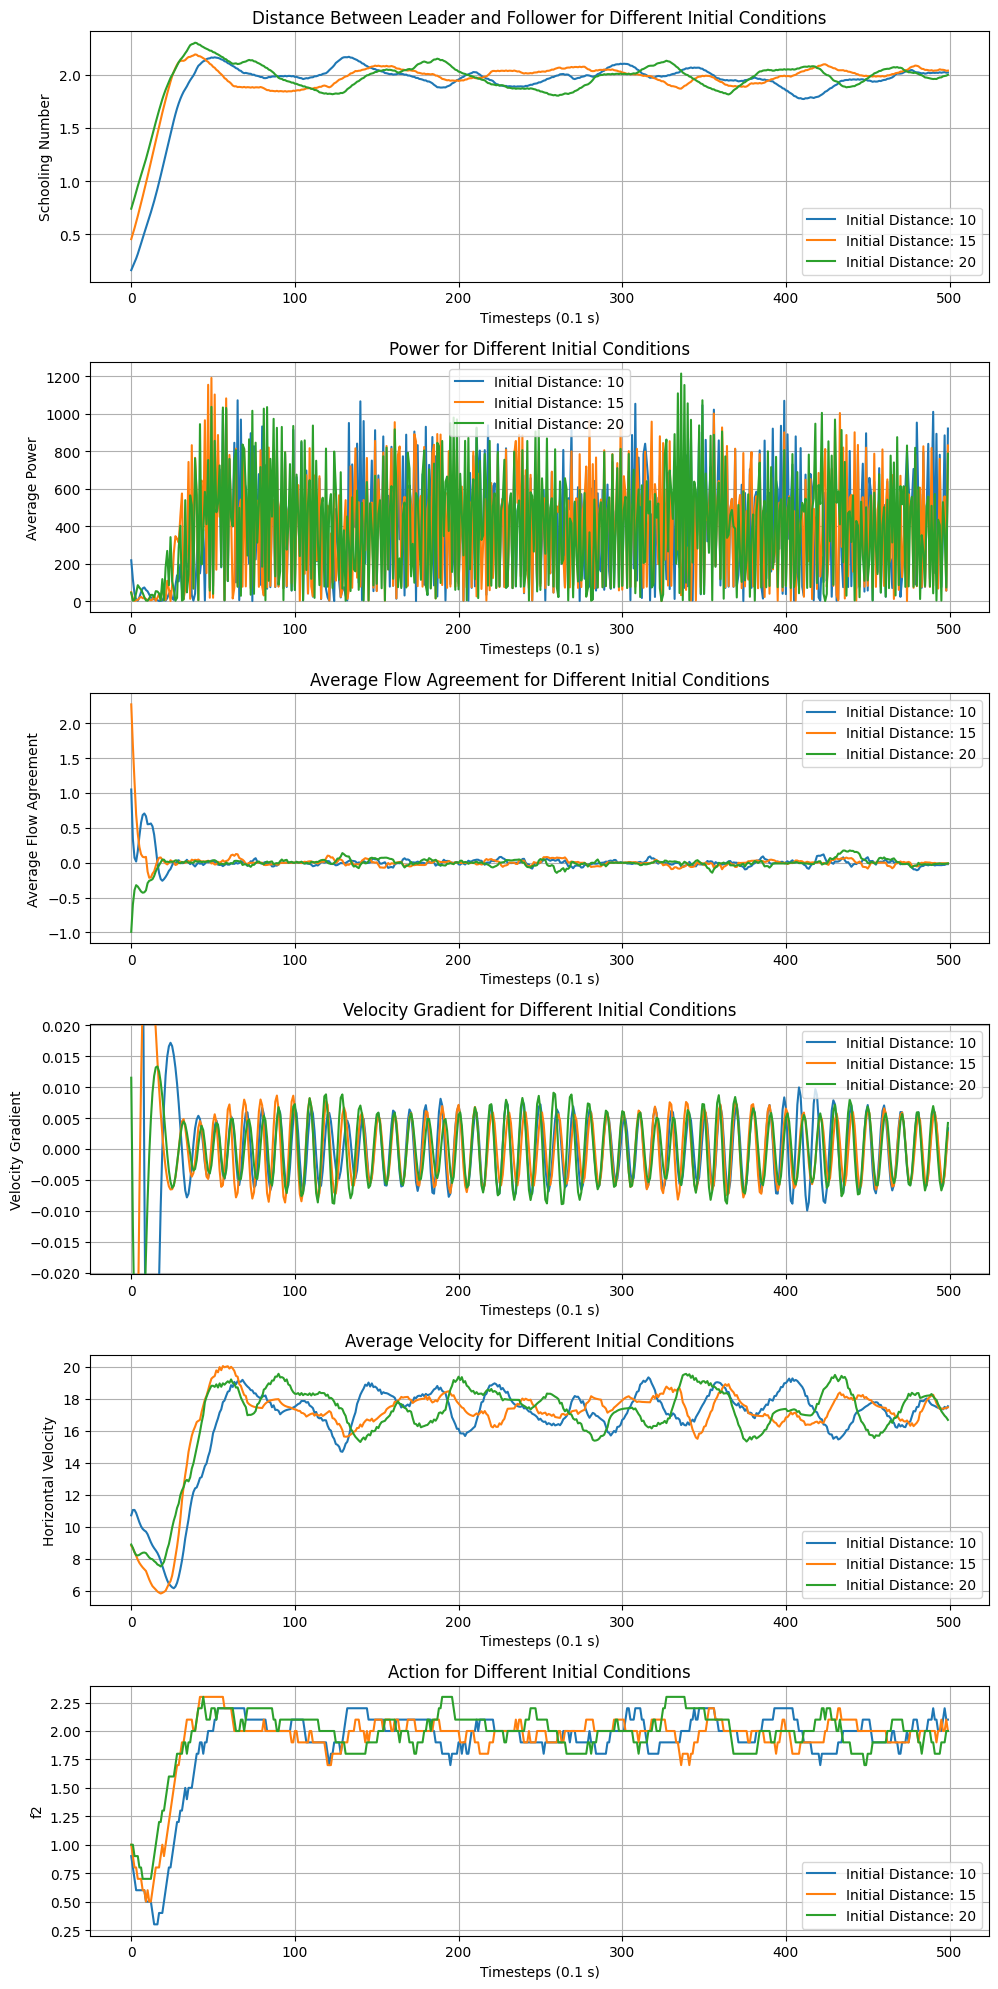

In [7]:
trainer.test_initial_conditions(InitialCondition(distance=dd, A2=1.) for dd in range(10, 21, 5))

(10000, 3)


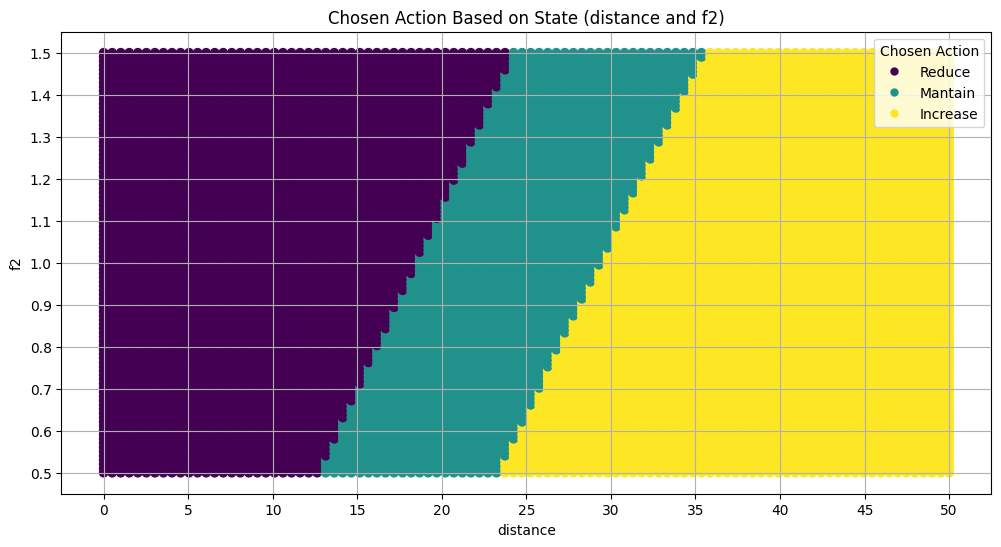

In [8]:
# plot the policy
fa_range = numpy.linspace(-10, 10, 100)
f2_range = numpy.linspace(0.5, 1.5, 100)
a2_range = numpy.linspace(0, 3, 100)
d_range = numpy.linspace(0, 50, 100)
u_range = numpy.linspace(0, 30, 100)
p_range = numpy.linspace(0, 1, 100)
trainer.plot_policy(
    fa_range=fa_range,
    f2_range=f2_range,
    a2_range=a2_range,
    d_range=d_range,
    u_range=u_range,
)

In [9]:
# trainer.create_video(time=20)